<a href="https://colab.research.google.com/github/VigneshwaraChinnadurai/Competitions/blob/master/Identify%20the%20snake%20breed/snake_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

In [2]:
!pip install fastai

In [3]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.1.9)


In [1]:
import numpy as np
import os
import pandas as pd
from fastai.vision.all import *

In [5]:
#STEP-1: Install Import Libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#STEP-2: Autheticate E-Mail ID

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1ES0Mdtd6rk2Z7eB6bjeSY0iIWi9X9Mrc'})
# replace the id with id of file you want to access
downloaded.GetContentFile('snake_classification_dataset.zip') 

#STEP-4: Read File

#3.1 Read file as panda dataframe
!unzip snake_classification_dataset.zip

Archive:  snake_classification_dataset.zip
replace dataset/train/bbac7385e2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/train/ef776b1488.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/train/190317f717.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/train/d7c292df19.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/train/461d5c01b8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n,a
replace dataset/train/a8dcaf77bd.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/train/a8dcaf77bd.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!ls

adc.json  dataset  models  sample_data	snake_classification_dataset.zip


In [3]:
dataset_path = Path('dataset/')
os.listdir(dataset_path)

['train', 'test.csv', 'test', 'train.csv']

In [4]:
train_df = pd.read_csv(dataset_path/'train.csv')

In [5]:
train_df.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [6]:
train_df['path'] = train_df['image_id'].map(lambda x:dataset_path/'train'/(x+'.jpg'))
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(5)

,breed,path
0,agkistrodon-contortrix,dataset/train/39028a791f.jpg
1,agkistrodon-piscivorus,dataset/train/75c287c659.jpg
2,agkistrodon-contortrix,dataset/train/b86e5edd29.jpg
3,storeria-dekayi,dataset/train/046d361aab.jpg
4,coluber-constrictor,dataset/train/7e993cca43.jpg


In [7]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 5508 images


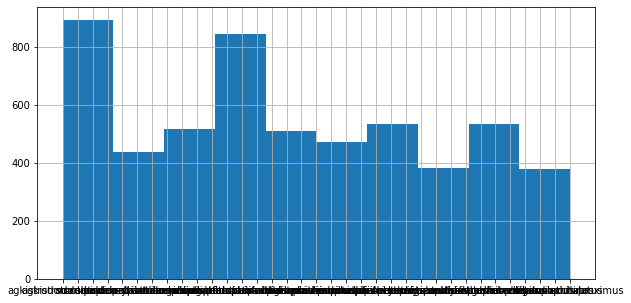

In [8]:
train_df['breed'].hist(figsize = (10, 5))

In [9]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

128 171


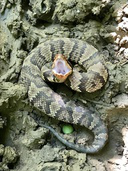

In [10]:
im

In [11]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [12]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               label_col=0, #label is in the first column of the DataFrame
                               fn_col=1, #filename/path is in the second column of the DataFrame
                               bs=bs, #pass in batch size
                               item_tfms=item_tfms, #pass in item_tfms
                               batch_tfms=batch_tfms) #pass in batch_tfms

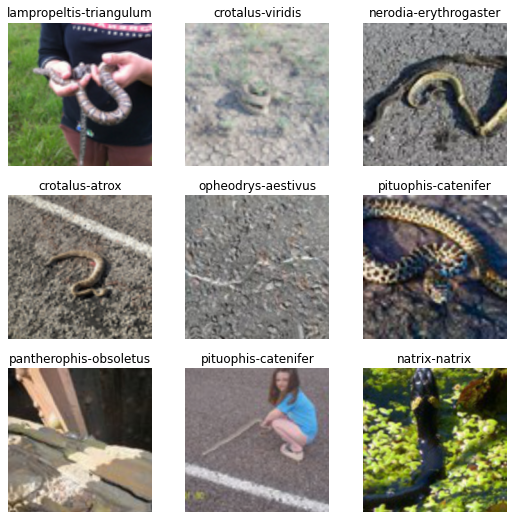

In [13]:
dls.show_batch()

In [14]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [15]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [16]:
learn = timm_learner(dls,
                     'tf_efficientnet_b3_ns', 
                     opt_func = ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     metrics = [accuracy]).to_native_fp16()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.015848932787775993)

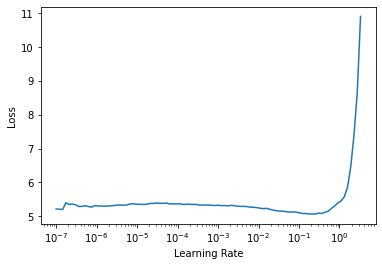

In [17]:
learn.lr_find()

In [18]:
learn.freeze()
learn.fit_flat_cos(1,1e-1, wd=0.5, cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,3.401622,2.841228,0.273388,00:42


In [19]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [20]:
learn = learn.load('stage-1')

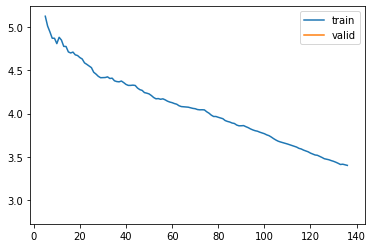

In [21]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=2.0892961401841603e-05)

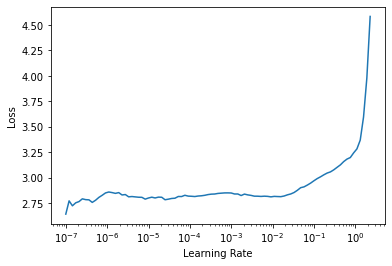

In [22]:
learn.unfreeze()
learn.lr_find()

In [23]:
learn.unfreeze()
learn.fit_flat_cos(100,2e-3,pct_start=0,cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,2.805555,2.599218,0.348774,00:54
1,2.663982,2.565317,0.362398,00:54
2,2.576676,2.541307,0.352407,00:53
3,2.474194,2.560687,0.356040,00:53
4,2.431267,2.512485,0.374205,00:53
5,2.402950,2.574453,0.354223,00:53
6,2.359312,2.610780,0.355132,00:54
7,2.303306,2.645354,0.336058,00:54
8,2.279799,2.672228,0.312443,00:53
9,2.183936,2.664720,0.343324,00:53


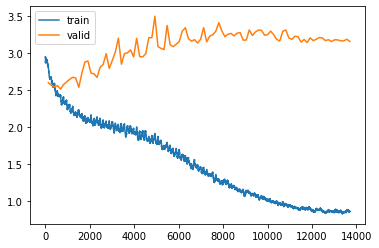

In [24]:
learn.recorder.plot_loss()

In [25]:
learn = learn.to_native_fp32()

In [26]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [27]:
learn.export()

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

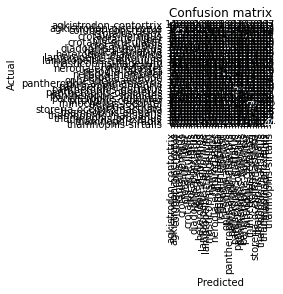

In [30]:
interp.plot_confusion_matrix()

In [31]:
sample_df = pd.read_csv(dataset_path/'test.csv')
sample_df.head()

,image_id
0,7ede553357
1,3500b219e4
2,d43a78d6d9
3,1f36f26994
4,8cb85fc58e


In [43]:
_sample_df = sample_df.copy()
_sample_df['path'] = _sample_df['image_id'].map(lambda x:dataset_path/'test'/(x+'.jpg'))
print(_sample_df.head(5))
test_dl = dls.test_dl(_sample_df)

print(test_dl)

     image_id                         path
0  7ede553357  dataset/test/7ede553357.jpg
1  3500b219e4  dataset/test/3500b219e4.jpg
2  d43a78d6d9  dataset/test/d43a78d6d9.jpg
3  1f36f26994  dataset/test/1f36f26994.jpg
4  8cb85fc58e  dataset/test/8cb85fc58e.jpg


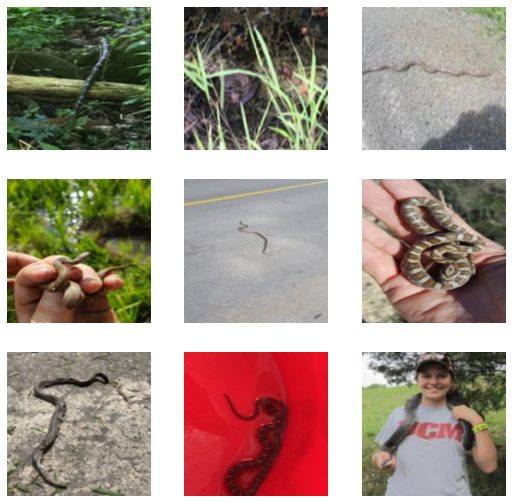

In [44]:
test_dl.show_batch()

In [45]:
preds, _ = learn.tta(dl=test_dl, n=8, beta=0)

In [46]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [47]:
sample_df.to_csv('submission.csv',index=False)

In [48]:
sample_df.head()

,image_id,label
0,7ede553357,23
1,3500b219e4,1
2,d43a78d6d9,22
3,1f36f26994,28
4,8cb85fc58e,2


In [49]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>